In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import cv2
import numpy as np


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import glob
import sklearn.metrics
import seaborn as sns
from keras.models import load_model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(77)

In [ ]:
!cd "/content/drive/MyDrive/oct"
!unzip -qq "/content/drive/MyDrive/oct/OCT_small.zip"

In [ ]:
total_dir = "/content/OCT_small"
train_dir = "/content/OCT_small/train"
test_dir = "/content/OCT_small/test"

In [ ]:
classes = os.listdir(train_dir)
print(classes)

['DME', 'NORMAL', 'CNV', 'DRUSEN']


In [ ]:
dataset = {
    "img_path" : [], 
    "class" : [], 
    "split" : []
}

for split in os.listdir(total_dir):
  for where in os.listdir(total_dir + "/" + split):
    for image in glob.glob(total_dir+"/"+split+"/"+where+"/*.jpeg"):
      dataset["img_path"].append(image)
      dataset["class"].append(where)
      dataset["split"].append(split)

dataset = pd.DataFrame(dataset)
dataset.head()

,img_path,class,split
0,/content/OCT_small/test/DME/DME-9931747-3.jpeg,DME,test
1,/content/OCT_small/test/DME/DME-3358004-19.jpeg,DME,test
2,/content/OCT_small/test/DME/DME-3606968-15.jpeg,DME,test
3,/content/OCT_small/test/DME/DME-7757895-2.jpeg,DME,test
4,/content/OCT_small/test/DME/DME-7949765-2.jpeg,DME,test


In [ ]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
valid_df = dataset[dataset["split"] == "validation"]

print(test_df.head(10))

                                          img_path class split
0   /content/OCT_small/test/DME/DME-9931747-3.jpeg   DME  test
1  /content/OCT_small/test/DME/DME-3358004-19.jpeg   DME  test
2  /content/OCT_small/test/DME/DME-3606968-15.jpeg   DME  test
3   /content/OCT_small/test/DME/DME-7757895-2.jpeg   DME  test
4   /content/OCT_small/test/DME/DME-7949765-2.jpeg   DME  test
5  /content/OCT_small/test/DME/DME-8699233-19.jpeg   DME  test
6   /content/OCT_small/test/DME/DME-3546221-1.jpeg   DME  test
7   /content/OCT_small/test/DME/DME-8123126-5.jpeg   DME  test
8   /content/OCT_small/test/DME/DME-3347866-4.jpeg   DME  test
9   /content/OCT_small/test/DME/DME-1805818-5.jpeg   DME  test


In [ ]:
len(train_df), len(test_df), len(valid_df)

(4995, 1425, 709)

In [ ]:
def makedf(df) : 
  samples = df[df["class"] == "NORMAL"].sample(frac=0.125, random_state=77)
  others = df[df["class"] != "NORMAL"]
  result = pd.concat([samples, others], axis=0)
  return result

In [ ]:
train_df = makedf(train_df)
test_df = makedf(test_df)
valid_df = makedf(valid_df)  

Text(0.5, 1.0, 'Validation Dataset')

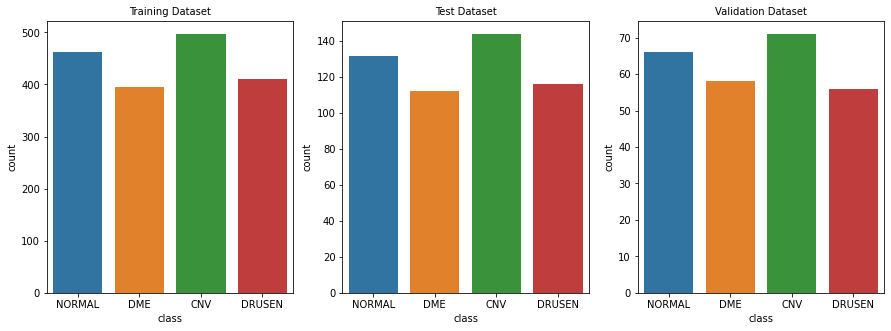

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["class"])
plt.title("Test Dataset", size=10)

plt.subplot(1, 3, 3)
sns.countplot(x=valid_df["class"])
plt.title("Validation Dataset", size=10)

In [ ]:
X_train = train_df["img_path"]
y_train = train_df["class"]

X_test = test_df["img_path"]
y_test = test_df["class"]

X_val = valid_df["img_path"]
y_val = valid_df["class"]


In [ ]:
for name in list(train_df["class"].unique()):
  print(name, len(train_df[train_df["class"] == name]))


NORMAL 462
DME 396
CNV 497
DRUSEN 410


In [ ]:
for name in list(test_df["class"].unique()):
  print(name, len(test_df[test_df["class"] == name]))


NORMAL 132
DME 112
CNV 144
DRUSEN 116


In [ ]:
for name in list(valid_df["class"].unique()):
  print(name, len(valid_df[valid_df["class"] == name]))


NORMAL 66
DME 58
CNV 71
DRUSEN 56


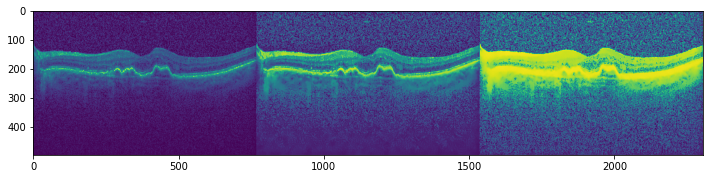

In [ ]:

sample = random.choice(dataset["img_path"])
#image = mpimg.imread(sample)
img = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
hist1 = cv2.calcHist(img, [0], None, [256], [0, 256])
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(img)
he = cv2.equalizeHist(img)

img2 = cv2.fastNlMeansDenoising(cl, None, 16, 7,21)
img3 = cv2.fastNlMeansDenoising(he, None, 16, 7,21)
res = np.hstack((img,img2, img3)) #stacking images side-by-side

plt.figure(figsize=(12, 5))
plt.imshow(res)
plt.show()

In [ ]:

datagen = ImageDataGenerator(
    
    rotation_range=30,
    horizontal_flip=True,
    fill_mode = "nearest"
)

In [ ]:
def norm_digit(img):
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32)
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

In [ ]:
from tqdm.notebook import tqdm
from skimage.color import rgb2gray
from skimage.transform import resize

def img_preprocess(imgs):
  images = []
  bar_total = tqdm(imgs)
  for file in bar_total:
          
          img = cv2.imread(file, 0)
          img = np.where(img == 255, 0, img)
          img = norm_digit(img)
          #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          #cl1 = cv2.fastNlMeansDenoising(img, None, 12, 7,21)
          #cl1 = clahe.apply(img)
          
        
          #images.append(resize(cl1, (128,128,3)))
          images.append(resize(img, (224,224,3)))
  images = np.array(images)
  return images

In [ ]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)
X_val = img_preprocess(X_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded

In [ ]:
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_val = makelabel(y_val)

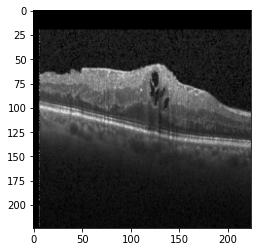

In [ ]:

plt.imshow(X_train[random.choice(range(len(X_train)))])

In [ ]:

datagen = ImageDataGenerator(

    rotation_range=10,
    horizontal_flip=True,
    fill_mode = "nearest"
)

In [ ]:
test_datagen = ImageDataGenerator()
    

In [ ]:

train_augment = datagen.flow(
    x=X_train, y=y_train, batch_size=5, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)

test_augment = test_datagen.flow(
    x=X_test, y=y_test, batch_size=1, 
    shuffle=True, sample_weight=None, seed=13,
    save_to_dir=None)


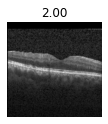

In [ ]:
augs = test_augment.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    plt.imshow(img.squeeze())

In [ ]:
base = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights=None, pooling="max")
input = tf.keras.layers.Input(shape=(224, 224, 3))
base = base(input)
out = tf.keras.layers.Dense(4, activation="softmax")(base)
model = tf.keras.models.Model(input, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy']
              )
#lr 줄이기 배치 늘리기 early stop 빼기

In [ ]:
history = model.fit(train_augment, 
                    validation_data = test_augment, batch_size=64, 
                    steps_per_epoch = len(X_train)/16, epochs=1000, 
                    )

Epoch 1/1000
110/110 [==============================] - 20s 126ms/step - loss: 3.0545 - accuracy: 0.2559 - val_loss: 3.0937 - val_accuracy: 0.2698
Epoch 2/1000
110/110 [==============================] - 13s 117ms/step - loss: 2.1242 - accuracy: 0.2793 - val_loss: 22.5871 - val_accuracy: 0.2857
Epoch 3/1000
110/110 [==============================] - 13s 117ms/step - loss: 1.9974 - accuracy: 0.2721 - val_loss: 2.2684 - val_accuracy: 0.2560
Epoch 4/1000
110/110 [==============================] - 13s 117ms/step - loss: 2.1478 - accuracy: 0.2721 - val_loss: 1.8582 - val_accuracy: 0.2262
Epoch 5/1000
110/110 [==============================] - 13s 116ms/step - loss: 1.9156 - accuracy: 0.2955 - val_loss: 1.9478 - val_accuracy: 0.2917
Epoch 6/1000
110/110 [==============================] - 13s 117ms/step - loss: 1.8977 - accuracy: 0.2486 - val_loss: 2.0389 - val_accuracy: 0.2242
Epoch 7/1000
110/110 [==============================] - 13s 117ms/step - loss: 2.0325 - accuracy: 0.2685 - val_loss: 

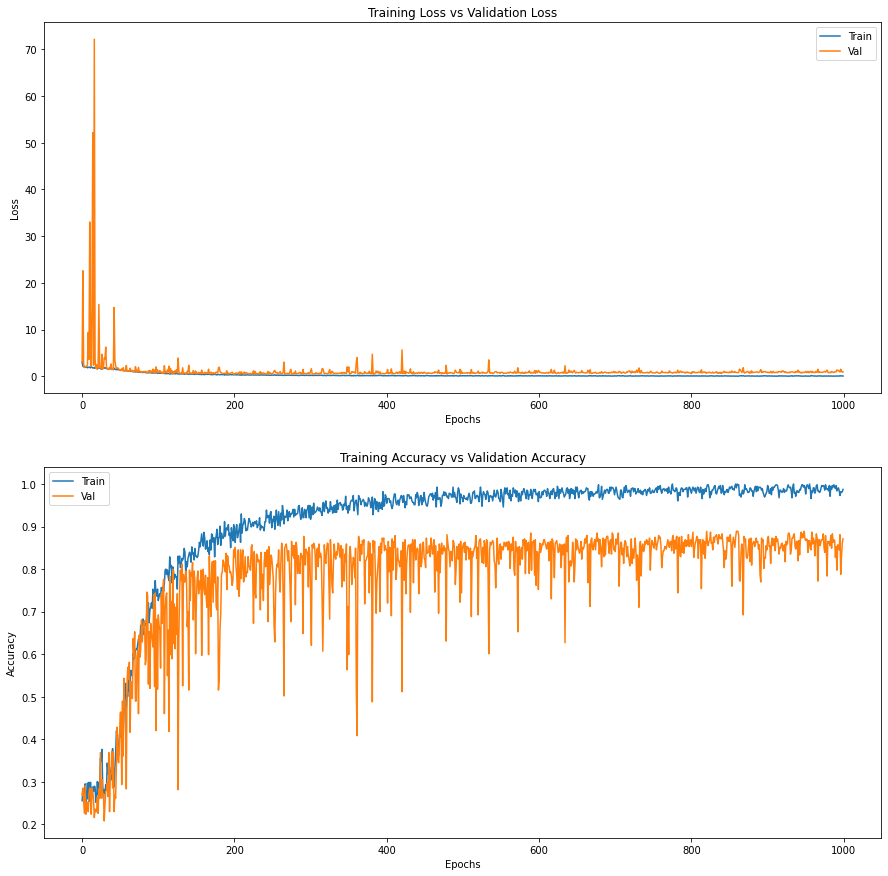

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
pred

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
confusion_matrix(y_val, pred)

In [ ]:
accuracy_score(y_val, pred)

In [ ]:
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]